In [26]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# import plotly.express as px

%matplotlib widget

<AxesSubplot:xlabel='Date'>

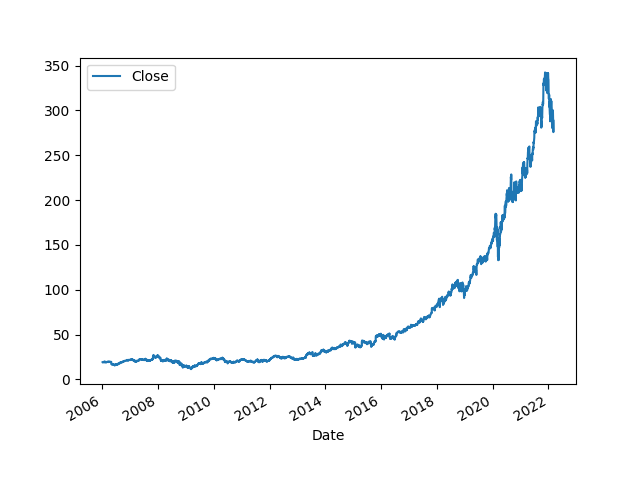

In [27]:
# get amazon data
data = yf.Ticker('MSFT').history(period='1d', start='2006-1-3')
# data = yf.Ticker('AMZN').history(period='1d')
data.plot(y='Close')
# px.line(data, y=['Close'])

In [28]:
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\kidin\AppData\Local\Temp\ipykernel_21156\1588348838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [29]:
from functions import split_data

lookback = 50 # sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [30]:
import torch as t
import torch.nn as nn

x_train = t.as_tensor(x_train, dtype=t.float32)
x_test = t.as_tensor(x_test, dtype=t.float32)
y_train = t.as_tensor(y_train, dtype=t.float32)
y_test = t.as_tensor(y_test, dtype=t.float32)


### Create the model, set the criterion, set the optimiser

In [31]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 150

In [32]:
from functions import LSTM, GRU

In [33]:
from functions import LSTM
from time import perf_counter

model_LSTM = LSTM(
    input_dim=input_dim, hidden_dim=hidden_dim,
    output_dim=output_dim, num_layers=num_layers)
criterion = nn.MSELoss(reduction='mean')
optimiser = t.optim.Adam(model_LSTM.parameters(), lr=0.01)

hist_lstm = np.zeros(num_epochs)
test_loss_lstm = np.zeros(num_epochs)
start_time = perf_counter()


optimiser.zero_grad()
for i in tqdm(range(num_epochs), desc='Epoch'):
    y_train_pred = model_LSTM(x_train)

    loss = criterion(y_train_pred, y_train)
    hist_lstm[i] = loss.item()
    with t.no_grad():
        test_loss_lstm[i] = criterion(y_test, model_LSTM(x_test)).item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = perf_counter() - start_time
print(f'Time to train: {training_time:0.2f}')

Epoch: 100%|██████████| 150/150 [01:44<00:00,  1.43it/s]

Time to train: 104.99


In [34]:
from functions import GRU
from time import perf_counter

model_GRU = GRU(
    input_dim=input_dim, hidden_dim=hidden_dim,
    output_dim=output_dim, num_layers=num_layers)
criterion = nn.MSELoss(reduction='mean')
optimiser = t.optim.Adam(model_GRU.parameters(), lr=0.01)

hist_gru = np.zeros(num_epochs)
test_loss_gru = np.zeros(num_epochs)
start_time = perf_counter()
lstm = []

optimiser.zero_grad()
for i in tqdm(range(num_epochs), desc='Epoch'):
    y_train_pred = model_GRU(x_train)

    loss = criterion(y_train_pred, y_train)
    hist_gru[i] = loss.item()
    with t.no_grad():
        test_loss_gru[i] = criterion(y_test, model_GRU(x_test)).item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = perf_counter() - start_time
print(f'Time to train: {training_time:0.2f}')


Epoch: 100%|██████████| 150/150 [01:38<00:00,  1.52it/s]

Time to train: 98.75


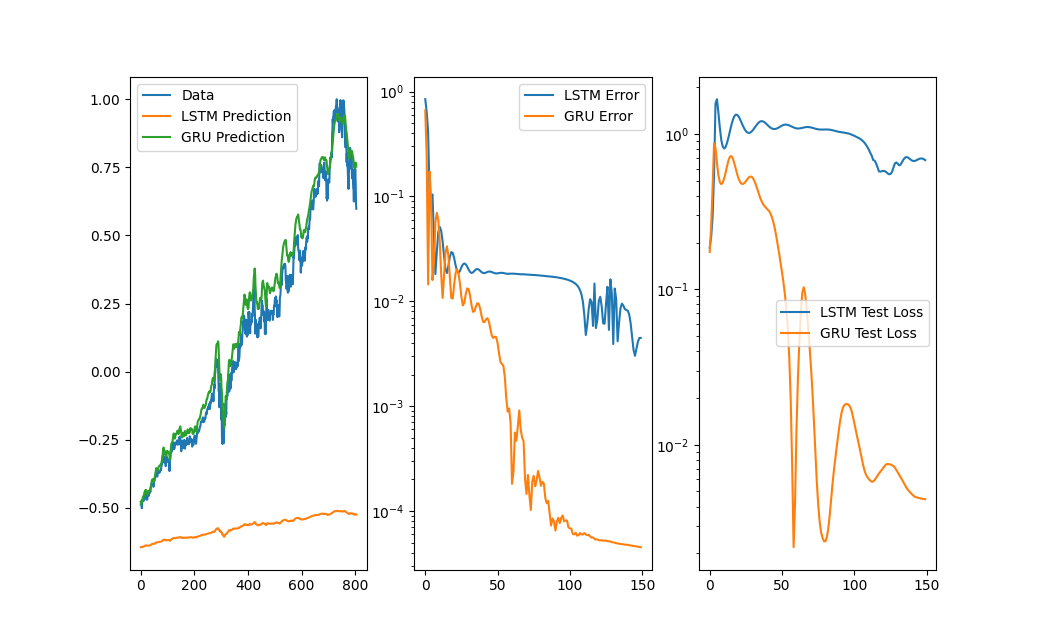

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(2, figsize=(10.4, 6.4))
fig.clear()

ax_right = fig.add_subplot(133)
ax_right.plot(test_loss_lstm, label='LSTM Test Loss')
ax_right.plot(test_loss_gru, label='GRU Test Loss')
ax_right.set_yscale('log')
plt.legend()

ax_mid = fig.add_subplot(132)
ax_mid.plot(hist_lstm, label='LSTM Error')
ax_mid.plot(hist_gru, label='GRU Error')
ax_mid.set_yscale('log')
plt.legend()

ax_left = fig.add_subplot(131)
ax_left.plot(t.squeeze(y_test).detach(), label='Data')
ax_left.plot(t.squeeze(model_LSTM(x_test)).detach(), label='LSTM Prediction')
ax_left.plot(t.squeeze(model_GRU(x_test)).detach(), label='GRU Prediction')
plt.legend()

plt.show()

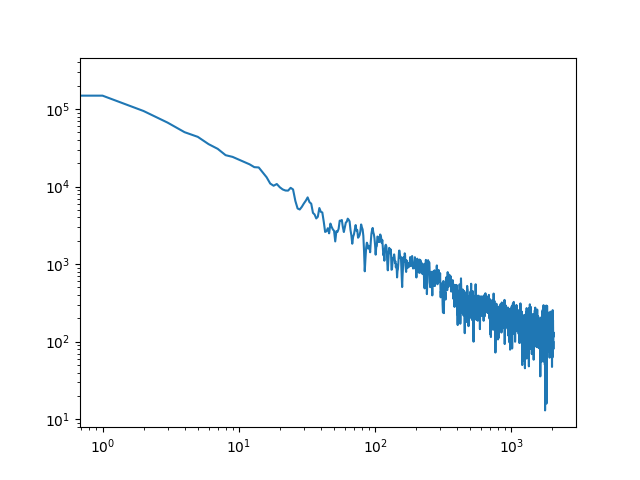

In [36]:
fig = plt.figure(20)
fig.clear()
ax = fig.add_subplot()
ax.plot(t.fft.rfft(t.as_tensor(data['Close'])).abs())
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [37]:
t.fft.fft(x_train[:, 0]).abs()


tensor([[0.9528],
        [0.9522],
        [0.9521],
        ...,
        [0.4544],
        [0.4331],
        [0.4446]])